In [1]:
from Shared.shared import *
from Shared.specific_CNB_sim import *
from Shared.specific_CNB_decay import *

## Loading PSDs from CLASS files

In [2]:
def make_PSD(z_val, plot=False, plot_q3f=False):

    # Construct the file path with the current value of i
    file_path = f"Data/test26_background.dat"

    # Open the file in read mode
    with open(file_path, 'r') as file:
        # Initialize a counter to keep track of lines read
        line_count = 0
        
        # Initialize an empty list to store the data from all columns
        all_columns_bg = []

        # Read each line from the file
        for line in file:
            # Increment the line count
            line_count += 1
            
            # Skip the first two lines
            if line_count <= 4:
                continue
            
            # Split the line into columns using whitespace as delimiter
            columns = line.split()

            # Dynamically adjust the size of all_columns_bg
            if len(all_columns_bg) == 0:
                # Initialize the all_columns_bg list with empty lists for each column
                all_columns_bg = [[] for _ in range(len(columns))]
            elif len(all_columns_bg) != len(columns):
                # Adjust the size of all_columns_bg if the number of columns changes
                diff = len(columns) - len(all_columns_bg)
                all_columns_bg.extend([] for _ in range(diff))

            # Append each column data to the corresponding list in all_columns_bg
            for j, column_data in enumerate(columns):
                all_columns_bg[j].append(float(column_data))

    del file

    q_size = 100

# for z_val in (1e9,4,0):

    z_idx = np.abs(np.array(all_columns_bg[0]) - z_val).argmin()

    lnf_all1 = [all_columns_bg[15 + i] for i in range(q_size)]
    lnf_s1 = [sublist[z_idx] for sublist in lnf_all1]
    lnf_d1 = np.array(lnf_s1, dtype=float)
    pref = (2*np.pi)**3 / 2
    f1 = pref*np.exp(lnf_d1)

    lnf_all2 = [all_columns_bg[118 + i] for i in range(q_size)]
    lnf_s2 = [sublist[z_idx] for sublist in lnf_all2]
    lnf_d2 = np.array(lnf_s2, dtype=float)

    # prefactor to convert CLASS output to real PSD
    pref = (2*np.pi)**3 / 2

    # exponentiate because CLASS gives lnf
    f2 = pref*np.exp(lnf_d2)

    q_ratio1 = np.arange(1, (q_size+1), 1)
    FD = 1 / (np.exp(q_ratio1) + 1)


    if plot:
        fig = plt.figure(figsize=(6,4))
        fig.tight_layout()
        ax1 = fig.add_subplot(111)

        if z_val > 1100:
            ax1.set_title(fr"PSDs at $z=z_{{\nu, \rm dec}}$")
        else:
            ax1.set_title(fr"PSDs at $z={z_val}$")


        if plot_q3f:
            factor = q_ratio1**3
        else:
            factor = 1.

        ax1.plot(q_ratio1, f1*factor, linestyle='-', label=r'Parent')
        ax1.plot(q_ratio1, f2*factor, linestyle='-', label=r'Daughter')
        ax1.plot(q_ratio1, FD*factor, color="magenta", linestyle=":", label=r"FD", alpha=0.5)

        ax1.set_xlabel(r"$q/T_{\nu,0}$")
        ax1.set_xscale('log')

        if plot_q3f:
            ax1.set_ylabel(r"$q^3 \, f(q)$")
            ax1.set_ylim(0, 3)
        else:
            ax1.axhline(0.5, color="red", ls="dotted", alpha=0.5, label="Max FD val")
            ax1.set_ylabel(r"$f(q)$")
            ax1.set_ylim(1e-22, 1e0)
            ax1.set_yscale('log')

        # Window to see shapes better, as q limits are still 1 to 100, not 0.01 to 400
        ax1.set_xlim(q_ratio1[0], 1e2)

        # Window as in my paper
        # ax1.set_xlim(q_ratio1[0], 1e1)
        # ax1.set_ylim(1e-2, 1e0)

        plt.legend()
        plt.grid(False)
        plt.show(); plt.close()


    return q_ratio1, f1, f2, FD

## Towards $n_\nu$ for no_gravity

### Preamble

In [3]:
sim_name = f"no_gravity_decay"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
simdata = SimData(sim_folder)
gamma_str ="0.1T"
decayed_neutrinos_index_z = jnp.load(
    f"{sim_folder}/decayed_neutrinos_index_z_{gamma_str}.npy",
    allow_pickle=True)
decayed_neutrinos_index_z_above_sim = jnp.load(
    f"{sim_folder}/decayed_neutrinos_index_z_above_sim_{gamma_str}.npy",
    allow_pickle=True)

# Load percentage values of total decayed neutrinos for specific gamma
gammas = np.array(["0.1T", "0.5T", "1T", "2T"])
g_idx = np.argwhere(gammas == gamma_str).flatten()[0]
decay_perc_data = np.load(f"{sim_folder}/decayed_neutrinos_perc.npy")

### Momentum analysis

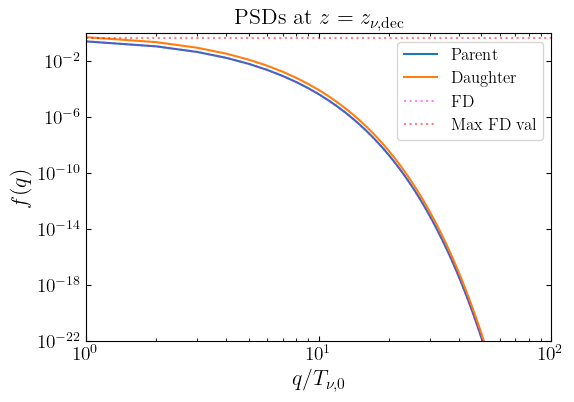

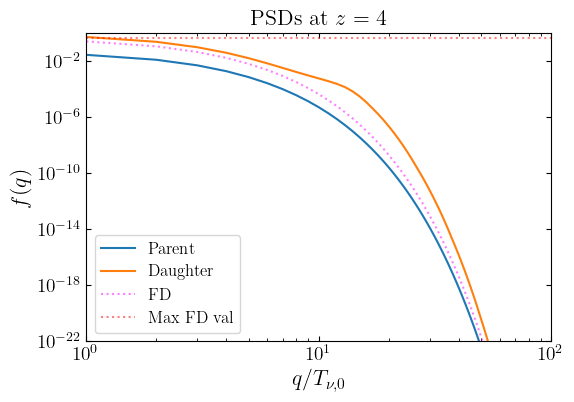

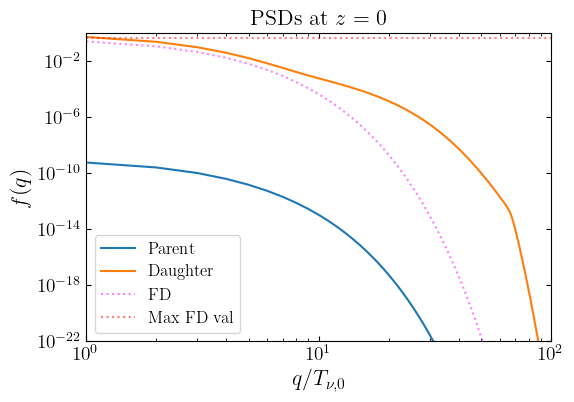

(1, 272755)
(1, 767931)
[False]


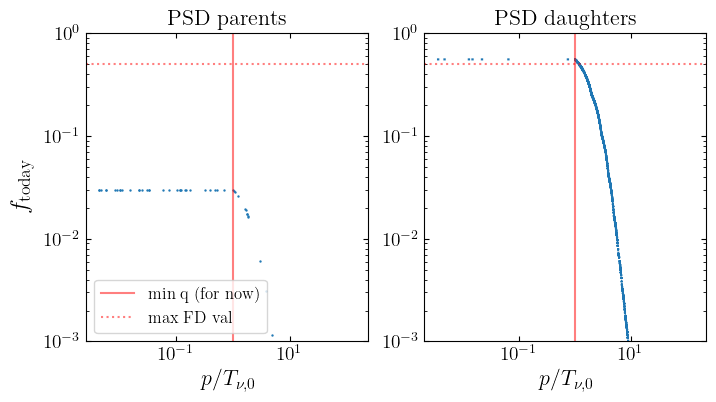

In [5]:
# Amount of daughter and parent neutrinos
daughter_neutrinos = int(decay_perc_data[g_idx] / 100 * simdata.nus_in_sim)
parent_neutrinos = simdata.nus_in_sim - daughter_neutrinos

# Indices of neutrinos that "switched" from daughters to parents during sim,
# and so are all the parents at sim boundary, and daughters at z=0
dp_ids = np.concatenate(
    [arr for arr in  decayed_neutrinos_index_z if arr.size > 0])

# Indices of neutrinos that decayed before sim boundary, and so are daughters
# at the sim boundary, and any point during the sim, and at z=0
d_ids = np.concatenate(
    [arr for arr in  decayed_neutrinos_index_z_above_sim if arr.size > 0])

# Indices of neutrinos that never decayed, and so are always parents
p_ids = np.setdiff1d(
    np.arange(simdata.nus_in_sim), 
    np.concatenate((dp_ids, d_ids), axis=None))

# print(switch_dp_ids.shape, always_d_ids.shape, always_p_ids.shape)
# print(switch_dp_ids.shape[0] + always_d_ids.shape[0])
# print(switch_dp_ids.shape[0] + always_d_ids.shape[0] + always_p_ids.shape[0])

# Load neutrino vectors from sim
nu_vectors = jnp.load(f'{sim_folder}/vectors_halo1.npy').reshape(-1, 2, 6)
nu_parents_z4 = nu_vectors[np.concatenate((p_ids, dp_ids), axis=None), -1]
nu_parents_z0 = nu_vectors[p_ids, 0]
nu_daughters_z4 = nu_vectors[d_ids, -1]
nu_daughters_z0 = nu_vectors[np.concatenate((d_ids, dp_ids), axis=None), 0]
# print(nu_parents_z4.shape[0] + nu_daughters_z4.shape[0])
# print(nu_parents_z0.shape[0] + nu_daughters_z0.shape[0])

# Convert to momenta
# nu_m_arr = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
parent_momenta_z4, _ = Physics.velocities_to_momenta_1D(
    nu_parents_z4[:, 3:], jnp.array([0.11186599]), Params())
parent_momenta_z0, _ = Physics.velocities_to_momenta_1D(
    nu_parents_z0[:, 3:], jnp.array([0.11186599]), Params())

daughter_momenta_z4, _ = Physics.velocities_to_momenta_1D(
    nu_daughters_z4[:, 3:], jnp.array([0.1]), Params())
daughter_momenta_z0, _ = Physics.velocities_to_momenta_1D(
    nu_daughters_z0[:, 3:], jnp.array([0.1]), Params())
# print(parent_momenta_z4[0].shape[0] + daughter_momenta_z4[0].shape[0])

# Sort momenta 
p_ind = parent_momenta_z0.argsort(axis=-1)
parent_z4_sort = jnp.take_along_axis(parent_momenta_z4, p_ind, axis=-1)
parent_z0_sort = jnp.take_along_axis(parent_momenta_z0, p_ind, axis=-1)

d_ind = daughter_momenta_z0.argsort(axis=-1)
daughter_z4_sort = jnp.take_along_axis(daughter_momenta_z4, d_ind, axis=-1)
#! upper two lines result in nan value in daughter_z4_sort array,
#! because shapes are different of _z4 and _z0 version...



# Interpolate PSDs from CLASS
plot_bool = True
q3f_bool = False
make_PSD(z_val=1e9, plot=plot_bool, plot_q3f=q3f_bool)
q_div_T, PSD_parent_z4, PSD_daughter_z4, _ = make_PSD(z_val=4, plot=plot_bool, plot_q3f=q3f_bool)
_, PSD_parent_z0, PSD_daughter_z0, _ = make_PSD(z_val=0, plot=plot_bool, plot_q3f=q3f_bool)

# note: correct procedure?
# We only care about daughters and parents at z0. Then we trace those back and find their corresponding momenta at z4. Parents will still be parents, but daughters might have "switched" to parents, so we have to use the parent distribution for those, when computing the number densities.

#? Liouville's theorem doesn't apply for neutrinos switching during sim?

daughter_z0_sort = jnp.take_along_axis(daughter_momenta_z0, d_ind, axis=-1)

print(daughter_momenta_z4.shape)
print(daughter_momenta_z0.shape)
print(jnp.unique(jnp.isnan(daughter_momenta_z4)))

# Input for interp function are momentum values at z4 of parents/daughter
parent_f_today = jnp.interp(
    parent_z4_sort[0]/Params.T_CNB, q_div_T, PSD_parent_z4)
daughter_f_today = jnp.interp(
    daughter_z4_sort[0]/Params.T_CNB, q_div_T, PSD_daughter_z4)
# daughter_f_today[daughter_f_today >= 0.5] = 0.5
daughter_f_today.at[daughter_f_today >= 0.5].set(0.5)

fig = plt.figure(figsize=(8,4))
fig.tight_layout()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title(fr"PSD parents")
ax1.scatter(
    parent_z0_sort[0]/Params.T_CNB, parent_f_today,
    s=0.5
)
ax1.set_ylim(1e-3,1e0)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel(fr"$p/T_{{\nu,0}}$")

ax2.set_title(fr"PSD daughters")
ax2.plot(
    daughter_z0_sort[0]/Params.T_CNB, daughter_f_today,
    # s=0.001
)
ax2.set_ylim(1e-3,1e0)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel(fr"$p/T_{{\nu,0}}$")

ax1.axvline(1, color="red", alpha=0.5, label="min q (for now)")
ax2.axvline(1, color="red", alpha=0.5)
ax1.axhline(0.5, color="red", alpha=0.5, ls=":", label="max FD val")
ax2.axhline(0.5, color="red", alpha=0.5, ls=":", label="max FD val")

# Common labels
# fig.text(0.5, 0.03, "Common X Label", ha='center')
fig.text(0.03, 0.5, fr"$f_{{\rm today}}$", va='center', rotation='vertical', fontsize=18)
ax1.legend(loc="lower left")

plt.show(); plt.close()

### PSD Analysis

### Number densities

In [10]:
def number_density(p_init, p_back, pix_sr, args):
    
    """Neutrino number density obtained by integration over initial momenta.

    Args:
        p_init (array): neutrino momentum today
        p_back (array): neutrino momentum at z_back (final redshift in sim.)

    Returns:
        array: Value of relic neutrino number density in (1/cm^3).
    """    

    # note: trapz integral method needs sorted (ascending) "x-axis" array.
    ind = p_init.argsort(axis=-1)
    p_init_sort = jnp.take_along_axis(p_init, ind, axis=-1)
    p_back_sort = jnp.take_along_axis(p_back, ind, axis=-1)
    
    zero_mask_init = (p_init_sort == 0)
    p_init_sort_y = jnp.copy(p_init_sort)
    p_init_sort = p_init_sort.at[zero_mask_init].set(1)
    # shape should be (masses, npix, neutrinos per pixel)
    
    # Fermi-Dirac values with momenta at end of sim
    FD_arr = Physics.Fermi_Dirac(p_back_sort, args)
    
    # Calculate number density
    y = p_init_sort_y**3 * FD_arr  # dlog integrand
    y = y.at[zero_mask_init].set(0) 
    x = p_init_sort

    n_raw = trap(y, jnp.log(x), axis=-1)

    # Multiply by constants and/or solid angles and convert to 1/cm**3.
    n_cm3 = pix_sr * args.g_nu/((2*args.Pi)**3) * n_raw / (1/args.cm**3)

    return jnp.array(n_cm3)


# As simple sum
log_integrand = parent_z0_sort[0]**3 * parent_f_today
log_int_array = parent_z0_sort[0]
# print(log_int_array)
n_raw = trap(log_integrand, jnp.log(log_int_array), axis=-1)
pix_sr_T, g_nu_T = 4*Params.Pi, 2.
n_cm3 = pix_sr_T * g_nu_T / ((2*Params.Pi)**3) * n_raw / (1/Params.cm**3)
print(n_cm3)
print(Params.N0_cm3-n_cm3)
print(decay_perc_data[g_idx] / 100 * Params.N0_cm3)
print(decay_perc_data[g_idx] / 100)
print(Params.N0_cm3)

log_integrand = daughter_z0_sort[0]**2 * daughter_f_today
log_int_array = daughter_z0_sort[0]
print(np.unique(np.isnan(log_integrand)))
# n_raw = trap(log_integrand, jnp.log(log_int_array), axis=-1)
n_raw = jnp.sum(log_integrand)
pix_sr_T, g_nu_T = 4*Params.Pi, 2.
n_cm3 = pix_sr_T * g_nu_T / ((2*Params.Pi)**3) * n_raw / (1/Params.cm**3)
print(n_cm3)

14.272726403818892
42.33639524776521
56.604108788549496
0.9999114477863574
56.609121651584104
[False  True]
nan
